In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state

In [2]:
def standardize(X,y):
    # Standardize X to have mean = 0 std = 1
    # Standardize y to have mean = 0
    X_scaled = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    y_scaled = y-np.mean(y)
    return X_scaled, y_scaled


def plot_coefficients(beta,alpha,alpha_opt=10,name=None):
    # Plotting regression coefficients vs lambda
    beta_opt = beta[:,np.argmin(np.abs(alpha-alpha_opt))]
    plt.figure()
    plt.plot(np.log10(alpha),beta.T,'-')
    plt.plot(np.log10(alpha_opt)*np.array([1,1]), [np.min(beta), np.max(beta)], 'k--')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\beta$')
    plt.title(name)
    plt.show()

def plot_CV_MSE(alpha_vals, mse, alpha_opt, name=None):
    mse_mean = np.mean(mse,axis=1)
    mse_std = np.std(mse,axis=1)
    plt.figure()
    plt.errorbar(np.log10(alpha_vals), mse_mean, mse_std)
    plt.plot(np.log10([alpha_opt,alpha_opt]), [0,np.max(mse)],'k--')
    plt.xlabel(r'log($\lambda$)')
    plt.ylabel('MSE')
    plt.title(name)
    plt.show()
    print('Optimal value of lambda is: ', np.round(alpha_opt,3))
        

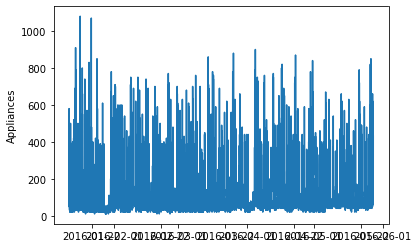

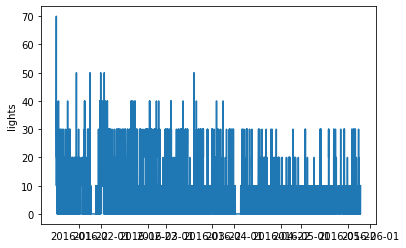

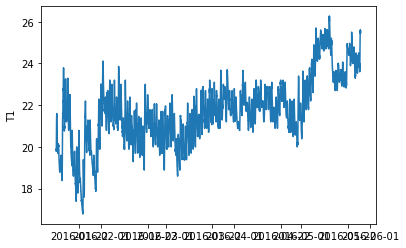

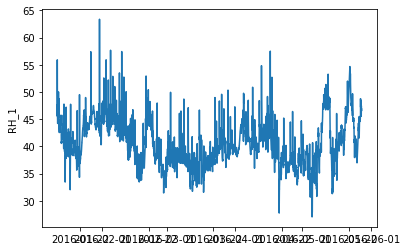

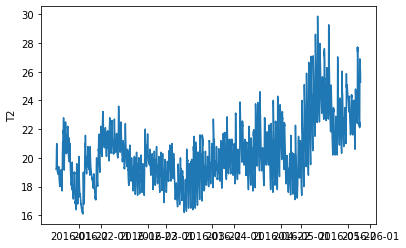

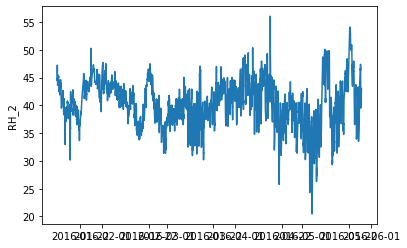

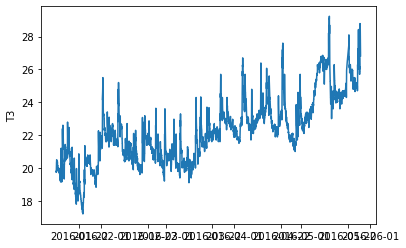

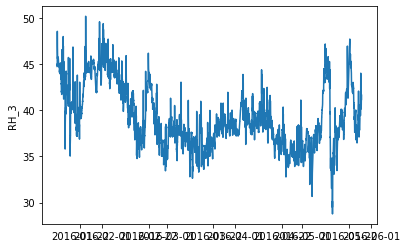

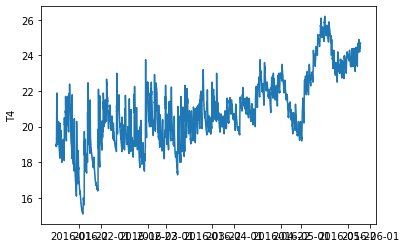

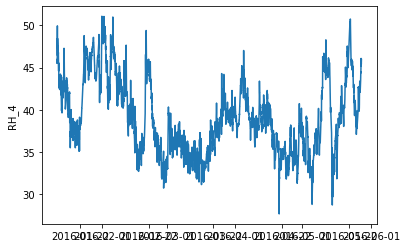

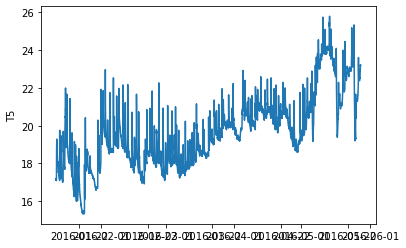

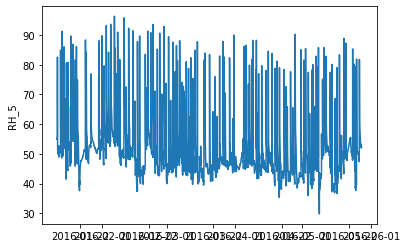

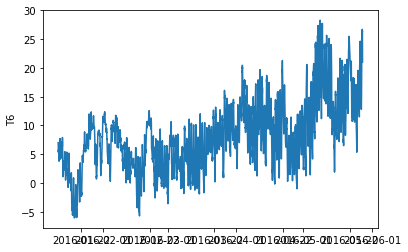

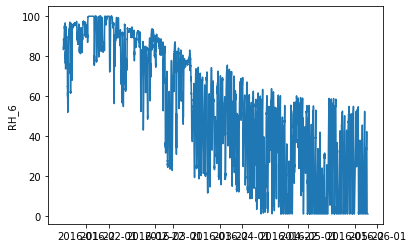

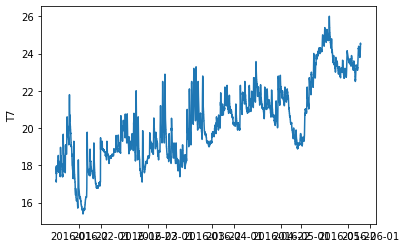

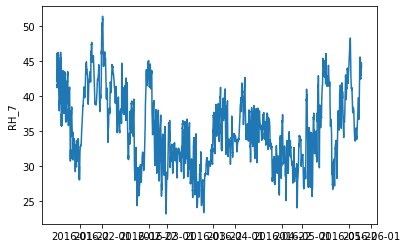

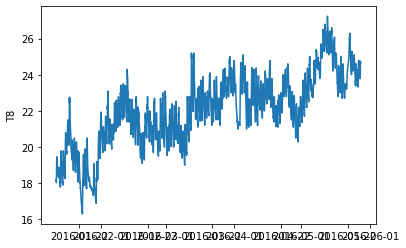

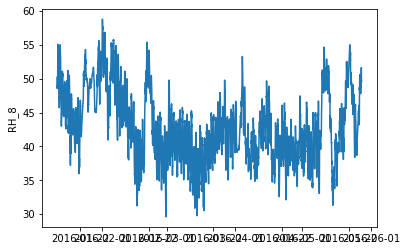

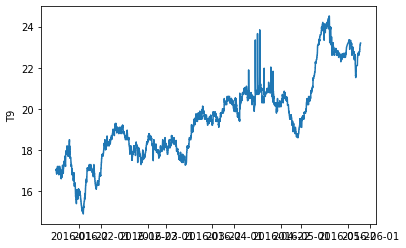

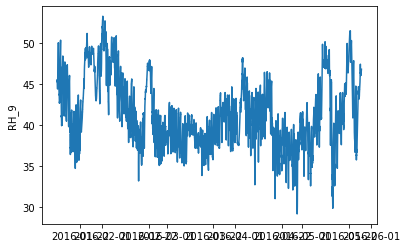

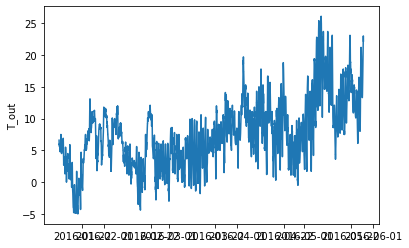

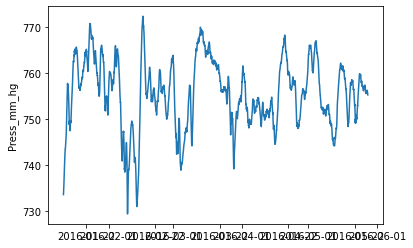

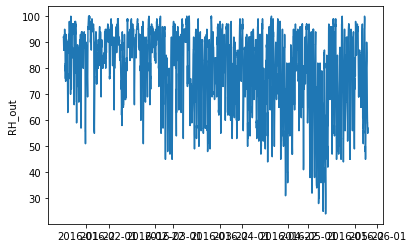

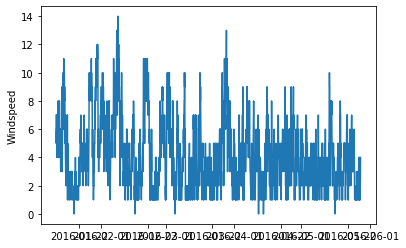

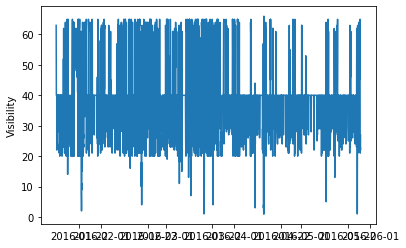

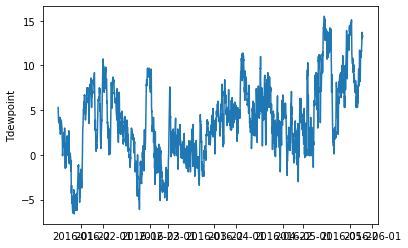

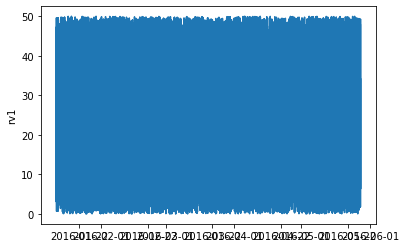

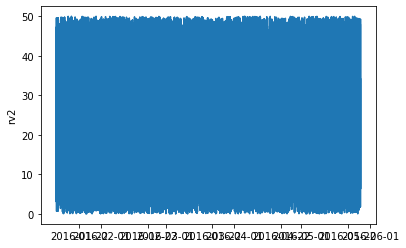

In [3]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

for i in range(len(df.columns)):
    plt.figure()
    plt.plot(df[df.columns[i]])
    plt.ylabel(df.columns[i])
    plt.show()

### Taking an n-hour mean

In [4]:
df = df.resample('24h').mean()

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [5]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i in range(len(df)):
    weekday[i] = df.index[i].weekday()
    weekstatus[i] = True if weekday[i] >= 5 else False  # False for workday, True for weekend
    NSM[i] = (df.index[i] - df.index[i].replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = df.index[i].month

df['weekday'] = weekday
df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month

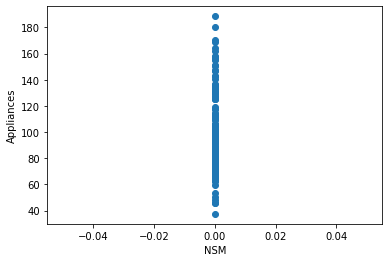

In [6]:
plt.figure()
plt.scatter(df['NSM'],df['Appliances'])
plt.xlabel('NSM')
plt.ylabel('Appliances')
plt.show()

### Filtering data and making training set
Example: Only february, after 16:00 and workday

In [7]:
#df_train = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_train = df[(df.index.month==2)]
df_train = df_train.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Training data
y = np.array(df_train['Appliances']).reshape(-1,1)
X = np.array(df_train[df_train.columns[1:]])
X, y = standardize(X,y)

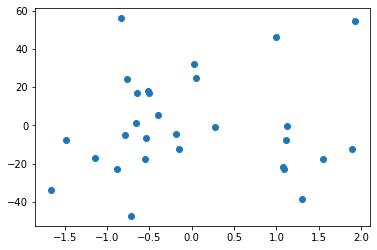

In [30]:
plt.figure()
plt.scatter(X[:,19],y)
plt.show()

### Cross validation

In [9]:
# Creating array of penalties

n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 100 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

#### CV Lasso

In [10]:
cv_lasso = linear_model.LassoCV(cv=10, random_state=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.565203765565911, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.329877980486344, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge.

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.869399732411239, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.315049874349711, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.192305591295053, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.055813582042447, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6813002016129985, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.358755663463171, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.55814955310956, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.52722804926833, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.610594294695147, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

#### CV Ridge

In [11]:
cv_ridge = linear_model.ElasticNetCV(cv=10, random_state=0, l1_ratio=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7344.802993631878, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7341.575408490704, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. 

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1792.6776505092816, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1728.1928639792918, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1665.9745158569008, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8393.913705069073, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8370.424457958983, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8346.010540844134, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4021.587871747144, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3924.172607815979, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3828.215240701044, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7974.027846326318, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7967.498851875486, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7960.422977956443, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4407.21964429402, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4316.449069542733, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4226.442293941165, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9381.557169516249, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9371.555468433166, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9360.779637891223, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4562.185216898219, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4452.154914129543, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4344.436289000279, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9421.002619416011, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9413.082189725872, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9404.536909547995, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5112.007718198492, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5005.566768155451, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4900.472288974633, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8855.501108225788, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8850.847284152815, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8845.756772063314, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5069.166952196744, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4962.342235416668, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4857.033506736498, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1983.8621528026622, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9331.684931435053, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9323.376516739507, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5147.004848068649, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5048.150238943581, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4951.568753087443, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2770.663574887263, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2704.264013902268, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2638.0096130631814, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6243.844858505536, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6133.7004987532655, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6023.702491248829, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2981.4585173504574, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2884.800918465863, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2788.5698035889845, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6477.5379792205, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6368.996875552603, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6260.024712857783, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3314.7883687150284, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3227.5036241271127, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3140.7326912216777, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4585.989765506029, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4494.351782236994, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4402.722440112279, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2205.6978684087126, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2142.9364150805, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080.5865006355457, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

#### CV Elastic net (0.5 ratio)

In [12]:
cv_elnet = linear_model.ElasticNetCV(cv=10, random_state=0, l1_ratio=0.5, fit_intercept=False, alphas=alpha_vals).fit(X, y)

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7574418571471142, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4350482838603966, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.338211954770486, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.35737289129702, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.22414721477662, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.804754121294536, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3618162702669, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.05425322661631, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergenc

In [13]:
print('Lasso score: ', cv_lasso.score(X,y))
print('Ridge score: ', cv_ridge.score(X,y))
print('Elastic net score: ', cv_elnet.score(X,y))

Lasso score:  0.6430340112780859
Ridge score:  0.5814605360634179
Elastic net score:  0.5140421348610485


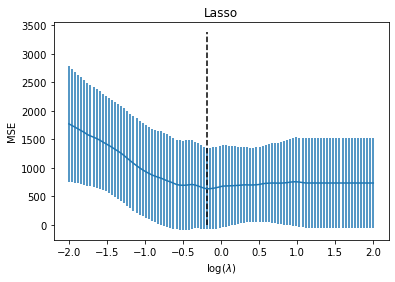

Optimal value of lambda is:  0.658


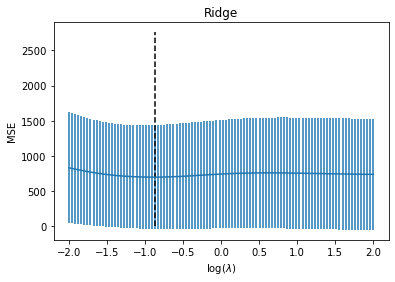

Optimal value of lambda is:  0.135


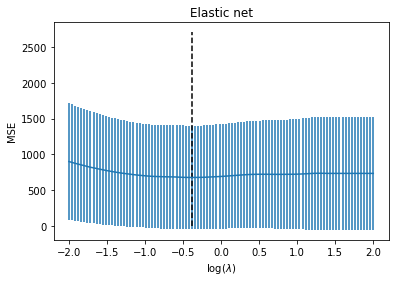

Optimal value of lambda is:  0.413


In [14]:
plot_CV_MSE(alpha_vals,cv_lasso.mse_path_,cv_lasso.alpha_, 'Lasso')
plot_CV_MSE(alpha_vals,cv_ridge.mse_path_,cv_ridge.alpha_, 'Ridge')
plot_CV_MSE(alpha_vals,cv_elnet.mse_path_,cv_elnet.alpha_, 'Elastic net')

### Lasso

In [15]:
beta_lasso = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.Lasso(alpha=alpha_vals[i], max_iter = 1000, fit_intercept = False)
    reg.fit(X,y)
    beta_lasso[:,i] = reg.coef_

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7478905294187825, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.632345416657699, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.496821637884295, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

### Ridge

In [16]:
beta_ridge = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter = 1000, l1_ratio=0, fit_intercept = False)
    reg.fit(X,y)
    beta_ridge[:,i] = reg.coef_

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9607.930662242881, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9602.741972930855, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9597.11041040267, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7697.065566170314, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7592.729495113143, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7485.840545823083, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

### Elastic net

In [17]:
beta_elnet = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter = 1000, l1_ratio=0.5, fit_intercept = False)
    reg.fit(X,y)
    beta_elnet[:,i] = reg.coef_

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.059365398720729, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.153778645855709, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.311096178618754, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

### Grouped Lasso
Does not work yet

In [33]:
beta_glasso = np.zeros((X.shape[1],n_alpha))

for i in range(n_alpha):
    reg = GroupLasso(
    group_reg=5,
    l1_reg=1,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
    )
    reg.fit(X, y)
    beta_glasso[:,i] = reg.coef_.reshape(-1,)

### Plotting coefficients vs lambda

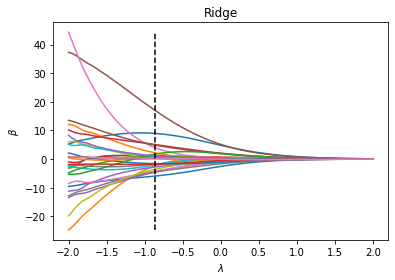

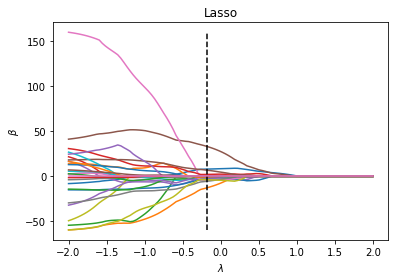

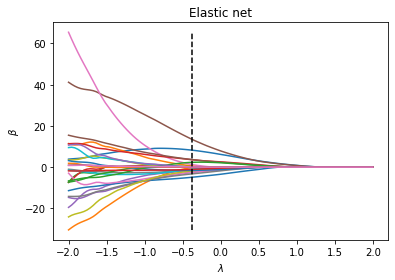

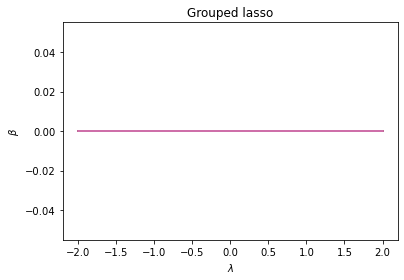

In [35]:
plot_coefficients(beta_ridge, alpha_vals, cv_ridge.alpha_, name='Ridge')
plot_coefficients(beta_lasso, alpha_vals, cv_lasso.alpha_, name='Lasso')
plot_coefficients(beta_elnet, alpha_vals, cv_elnet.alpha_, name='Elastic net')
plot_coefficients(beta_glasso,alpha_vals,1,name='Grouped lasso')

In [20]:
data = {'Feature': list(df_train.columns[1:])}
df_results = pd.DataFrame(data)
df_results['Lasso'] = beta_lasso[:,alpha_vals==cv_lasso.alpha_]
df_results['Ridge'] = beta_ridge[:,alpha_vals==cv_ridge.alpha_]
df_results['Elastic net'] = beta_elnet[:,alpha_vals==cv_elnet.alpha_]
df_results

,Feature,Lasso,Ridge,Elastic net
0,lights,8.015377,8.968021,8.244349
1,T1,-12.777056,-2.421738,-0.195598
2,RH_1,-0.000000,0.536322,0.000000
3,T2,-0.000000,1.190021,0.089832
4,RH_2,-1.978006,-2.801881,-1.692045
5,T3,33.238377,17.114000,13.589429
6,RH_3,0.000000,4.072997,1.293192
7,T4,-3.899298,-1.747808,-1.211990
8,RH_4,-0.000000,0.307880,-0.000000
9,T5,-0.619641,-2.091211,-1.032950


### Testing with another month

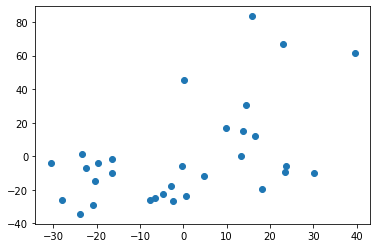

0.6430340112780859
0.2551880333923938


In [32]:
#df_test = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_test = df[(df.index.month==3)]
df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Testing data
y_t = np.array(df_test['Appliances']).reshape(-1,1)
X_t = np.array(df_test[df_test.columns[1:]])
X_t, y_t = standardize(X_t,y_t)

reg = linear_model.ElasticNet(alpha=cv_elnet.alpha_, max_iter = 1000, l1_ratio=0.5, fit_intercept = False)
reg = linear_model.Lasso(alpha=cv_lasso.alpha_, max_iter = 1000, fit_intercept = False)
reg.fit(X,y)
y_p = reg.predict(X_t)

plt.figure()
plt.scatter(y_p,y_t)
plt.show()
print(reg.score(X,y))
print(reg.score(X_t,y_t))